## KNN으로 다음 거래일의 상승, 하락 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [3]:
df = web.DataReader("SPY", data_source="yahoo", start="2015-01-01", end="2020-01-01")[['Open', 'High', 'Low', 'Close']]
df.head()

,Open,High,Low,Close
Date,,,,
2014-12-31,207.990005,208.190002,205.389999,205.539993
2015-01-02,206.380005,206.880005,204.179993,205.429993
2015-01-05,204.169998,204.369995,201.350006,201.720001
2015-01-06,202.089996,202.720001,198.860001,199.820007
2015-01-07,201.419998,202.720001,200.880005,202.309998


In [4]:
df = df.dropna()
df['Open-Close'] = df.Open - df.Close
df["High-Low"] = df.High - df.Low
X = df[['Open-Close', 'High-Low']]

In [7]:
# 전날보다 당일이 더 크면 +1, 아니면 -1

y = np.where(df['Close'].shift(-1) > df['Close'], +1, -1)

In [8]:
train_pct = 0.7
split = int(train_pct*len(df))

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

In [9]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [10]:
accuracy_train = accuracy_score(y_train, knn.predict(X_train))
accuracy_test = accuracy_score(y_test, knn.predict(X_test))

print("train acc :", accuracy_train)
print("test acc :", accuracy_test)

# 54%.. 유의미한 수치는 아닌것같음

train acc : 0.6276958002270148
test acc : 0.544973544973545


In [13]:
# 전략 검증

df["Signal"] = knn.predict(X)
df["SPY_Returns"] = np.log(df["Close"]/df["Close"].shift(1))  # SNP 일간수익률
Cum_SPY_Returns = df[split:]["SPY_Returns"].cumsum()*100  # 훈련기간 데이터는 제외한 SNP 누적수익률

df["STR_Returns"] = df["SPY_Returns"]*df["Signal"].shift(1)  # 전략의 일간수익률 계산
Cum_STR_Returns = df[split:]["STR_Returns"].cumsum()*100  # 전략 누적수익률 계산

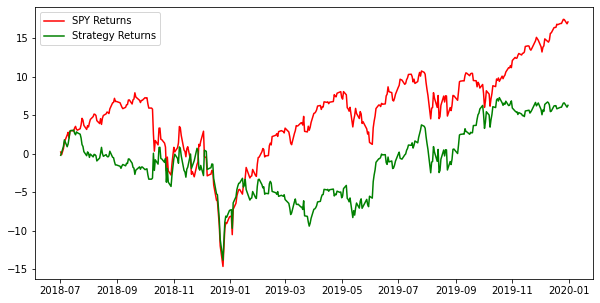

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(Cum_SPY_Returns, color='r', label="SPY Returns")
plt.plot(Cum_STR_Returns, color='g', label="Strategy Returns")
plt.legend()
plt.show()

# 정답률이 저조하며 수익률 역시 하회함

In [15]:
# 샤프비율 계산
Std= Cum_STR_Returns.std()

Sharpe = (Cum_STR_Returns - Cum_SPY_Returns)/Std
Sharpe = Sharpe.mean()
print("Sharpe ratio :", Sharpe)

# 샤프비율도 음수가 나오므로 나쁜 전략

Sharpe ratio : -1.4192185511962598
